# DID（差分の差分法）
処置群（介入を受けたグループ）の変化と対照群（介入を受けていないグループ）の変化の差分をとることで、「あるグループに何かしらの介入（政策や施策など）を実施したとき、実施しなかったグループと比べてどのくらい変化したのか？」を分析するための因果推論手法。

https://chatgpt.com/c/67b1ce9a-710c-8006-958f-d13688145d00

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [67]:
# データ読み込み
df = pd.read_csv("../data/Retailrocket recommender system dataset/events.csv")
df

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


- timestamp: イベントの発生時刻（ミリ秒単位）
- visitorid: ECサイトを訪問したユーザーを一意に識別するID
- event: ユーザーの行動（view, addtocart, transaction）
- itemid: 商品ID
- transactionid: 購入が発生した場合に記録される取引ID（NaNでない場合は購入）

In [68]:
# ミリ秒のUNIX時間を日付に変換
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

# 日付のみに変換
df["date"] = df["timestamp"].dt.date

# 取引データのみを抽出
df_sales = df[df["event"] == "transaction"]
df_sales

,timestamp,visitorid,event,itemid,transactionid,date
130,2015-06-02 05:17:56.276,599528,transaction,356475,4000.0,2015-06-02
304,2015-06-01 21:18:20.981,121688,transaction,15335,11117.0,2015-06-01
418,2015-06-01 21:25:15.008,552148,transaction,81345,5444.0,2015-06-01
814,2015-06-01 16:38:56.375,102019,transaction,150318,13556.0,2015-06-01
843,2015-06-01 16:01:58.180,189384,transaction,310791,7244.0,2015-06-01
...,...,...,...,...,...,...
2755294,2015-07-31 21:12:56.570,1050575,transaction,31640,8354.0,2015-07-31
2755349,2015-07-31 21:57:58.779,861299,transaction,456602,3643.0,2015-07-31
2755508,2015-07-31 15:48:50.123,855941,transaction,235771,4385.0,2015-07-31
2755603,2015-07-31 15:12:40.300,548772,transaction,29167,13872.0,2015-07-31


In [69]:
# 割引を受けた商品（処置群）を定義
df_sales["discounted"] = df_sales["itemid"].apply(lambda x: 1 if 100000 <= x <= 200000 else 0)

df_sales

C:\Users\fuben\AppData\Local\Temp\ipykernel_7360\958557618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales["discounted"] = df_sales["itemid"].apply(lambda x: 1 if 100000 <= x <= 200000 else 0)


,timestamp,visitorid,event,itemid,transactionid,date,discounted
130,2015-06-02 05:17:56.276,599528,transaction,356475,4000.0,2015-06-02,0
304,2015-06-01 21:18:20.981,121688,transaction,15335,11117.0,2015-06-01,0
418,2015-06-01 21:25:15.008,552148,transaction,81345,5444.0,2015-06-01,0
814,2015-06-01 16:38:56.375,102019,transaction,150318,13556.0,2015-06-01,1
843,2015-06-01 16:01:58.180,189384,transaction,310791,7244.0,2015-06-01,0
...,...,...,...,...,...,...,...
2755294,2015-07-31 21:12:56.570,1050575,transaction,31640,8354.0,2015-07-31,0
2755349,2015-07-31 21:57:58.779,861299,transaction,456602,3643.0,2015-07-31,0
2755508,2015-07-31 15:48:50.123,855941,transaction,235771,4385.0,2015-07-31,0
2755603,2015-07-31 15:12:40.300,548772,transaction,29167,13872.0,2015-07-31,0


<Axes: >

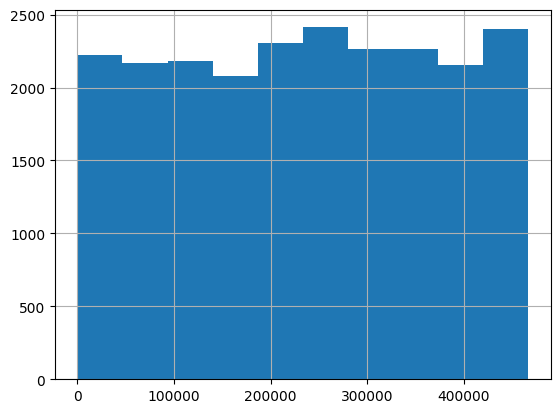

In [74]:
df_sales['itemid'].hist()

In [70]:
# 割引開始日
discount_start_date = pd.to_datetime("2015-07-01").date()

# 割引前・後のフラグ
df_sales["post_discount"] = df_sales["date"].apply(lambda x: 1 if x >= discount_start_date else 0)
df_sales

C:\Users\fuben\AppData\Local\Temp\ipykernel_7360\2515112233.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales["post_discount"] = df_sales["date"].apply(lambda x: 1 if x >= discount_start_date else 0)


,timestamp,visitorid,event,itemid,transactionid,date,discounted,post_discount
130,2015-06-02 05:17:56.276,599528,transaction,356475,4000.0,2015-06-02,0,0
304,2015-06-01 21:18:20.981,121688,transaction,15335,11117.0,2015-06-01,0,0
418,2015-06-01 21:25:15.008,552148,transaction,81345,5444.0,2015-06-01,0,0
814,2015-06-01 16:38:56.375,102019,transaction,150318,13556.0,2015-06-01,1,0
843,2015-06-01 16:01:58.180,189384,transaction,310791,7244.0,2015-06-01,0,0
...,...,...,...,...,...,...,...,...
2755294,2015-07-31 21:12:56.570,1050575,transaction,31640,8354.0,2015-07-31,0,1
2755349,2015-07-31 21:57:58.779,861299,transaction,456602,3643.0,2015-07-31,0,1
2755508,2015-07-31 15:48:50.123,855941,transaction,235771,4385.0,2015-07-31,0,1
2755603,2015-07-31 15:12:40.300,548772,transaction,29167,13872.0,2015-07-31,0,1


In [71]:
# 商品ごとに売上回数をカウント
df_did = df_sales.groupby(["date", "discounted", "post_discount"]).size().reset_index(name="sales")

# データ確認
df_did.head()

,date,discounted,post_discount,sales
0,2015-05-03,0,0,75
1,2015-05-03,1,0,8
2,2015-05-04,0,0,122
3,2015-05-04,1,0,32
4,2015-05-05,0,0,169


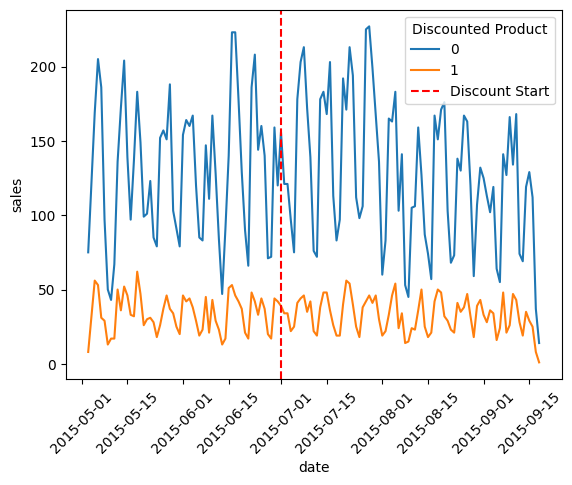

In [72]:
# 割引前後の売上トレンド
sns.lineplot(data=df_did, x="date", y="sales", hue="discounted")
plt.axvline(discount_start_date, color='red', linestyle="--", label="Discount Start")
plt.legend(title="Discounted Product")
plt.xticks(rotation=45)
plt.show()

In [73]:
# ダミー変数の作成
df_did["interact"] = df_did["discounted"] * df_did["post_discount"]

# 回帰モデルの構築
X = sm.add_constant(df_did[["post_discount", "discounted", "interact"]])
y = df_did["sales"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     172.2
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           9.64e-63
Time:                        21:58:33   Log-Likelihood:                -1380.4
No. Observations:                 278   AIC:                             2769.
Df Residuals:                     274   BIC:                             2783.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           129.7627      4.550     28.521